##  OCT Segmentation Results
Visualize results generated by the train_oct.py script.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import h5py
from functools import partial

import sys, time
import numpy as np
import pylab as plt
from scipy.io import loadmat


sys.path.append('../..')
import cnn_tools as ct
import train_oct

Using Theano backend.


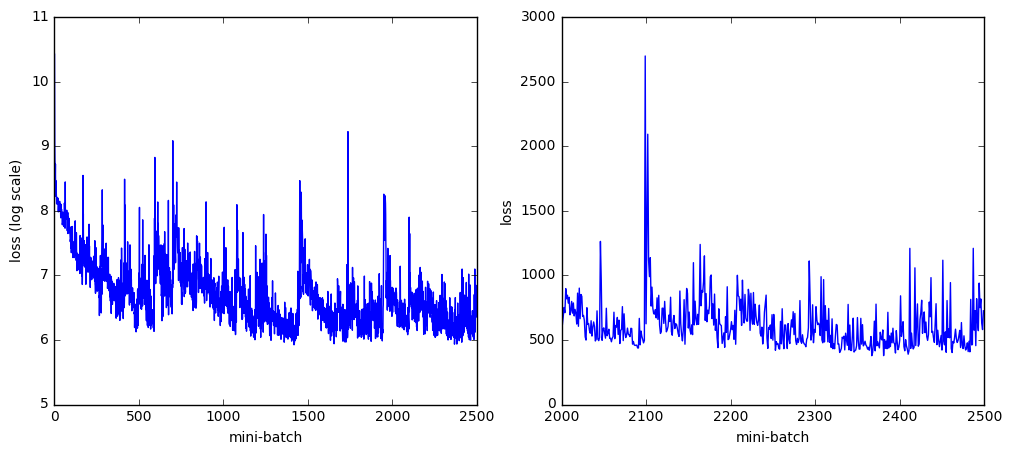

In [2]:
# Look at how training evolved
fn = 'oct_seg_fold0_valid_epoch0099.npz'

if os.path.exists(fn):
    f = np.load(fn)
    loss = f['s']
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(np.log(loss))
    plt.ylabel('loss (log scale)')
    plt.xlabel('mini-batch')
        
    plt.subplot(1,2,2)
    plt.plot(np.arange(len(loss)-500, len(loss)), loss[-500:])
    plt.xlabel('mini-batch')
    plt.ylabel('loss')

else:
    print('weight file %s not found' % fn)
    

In [3]:
# For now, just load results that were pre-computed on the cluster.
# My laptop is struggling to even deploy this stuff.

f = np.load('oct_seg_fold0_deploy_final.npz')

X = f['X']
Y = f['Y']
Y_hat = f['Y_hat']
test_slices = f['test_slices']
valid_slices = f['valid_slices']

train_slices = [x for x in range(50) if x not in test_slices and x not in valid_slices]

print('X shape:     ', X.shape)
print('Y shape:     ', Y.shape)
print('Y_hat shape: ', Y_hat.shape)
print('test slices are: ', test_slices)

X shape:      (50, 1, 512, 968)
Y shape:      (50, 1, 512, 968)
Y_hat shape:  (50, 512, 968)
test slices are:  [ 0  5 10 15 20 25 30 35 40 45]


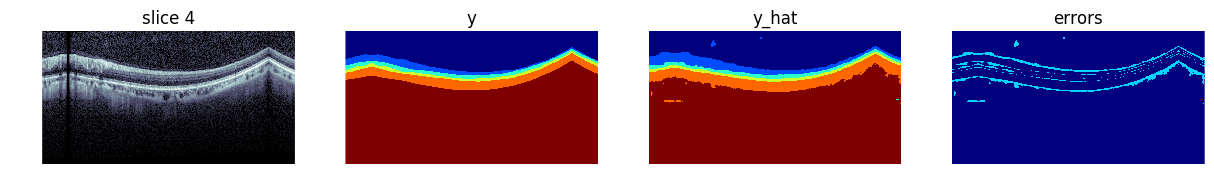

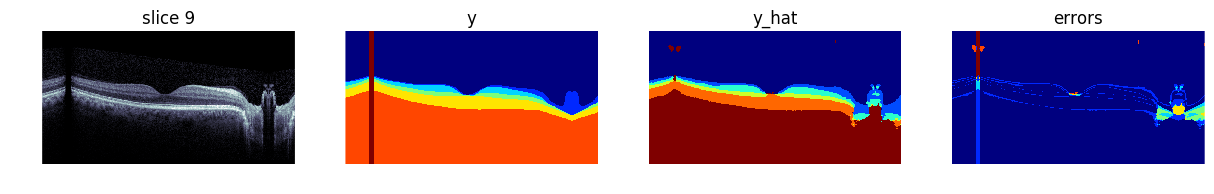

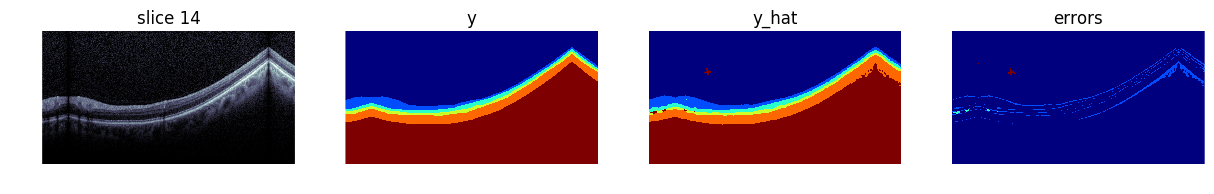

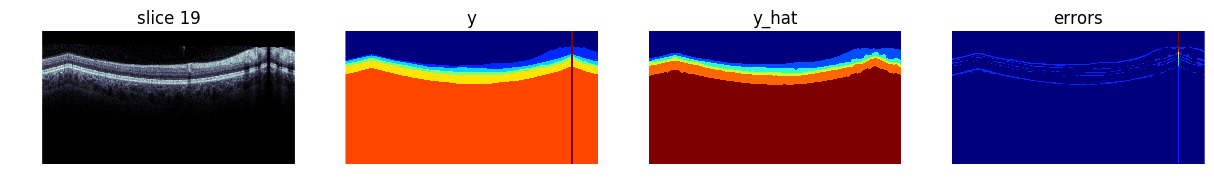

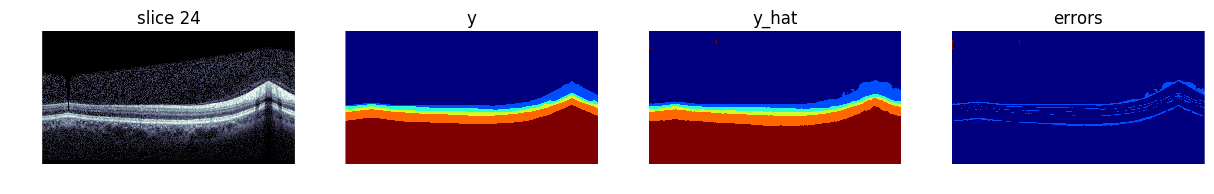

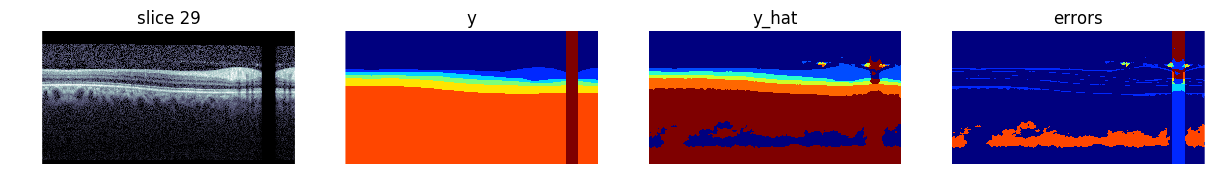

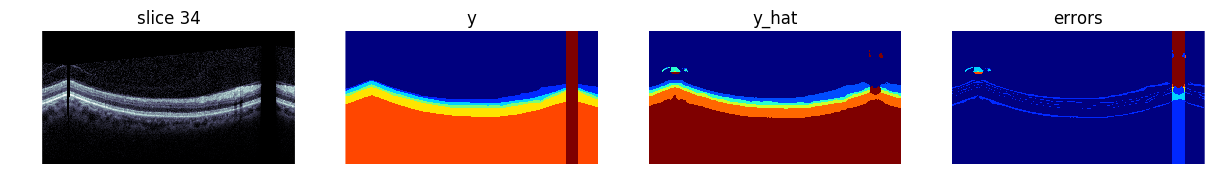

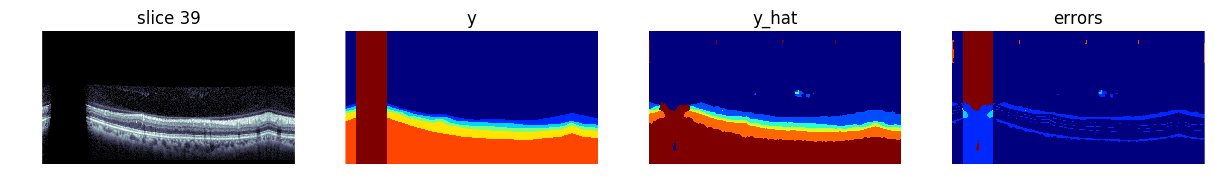

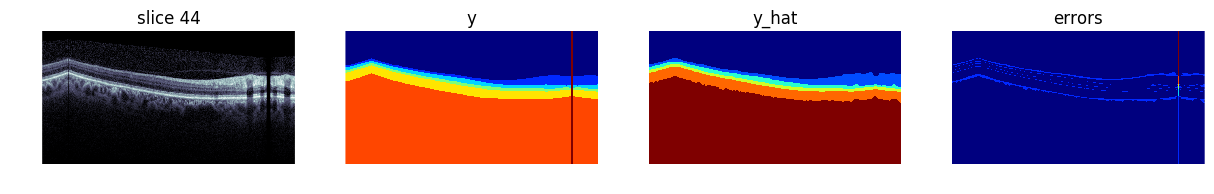

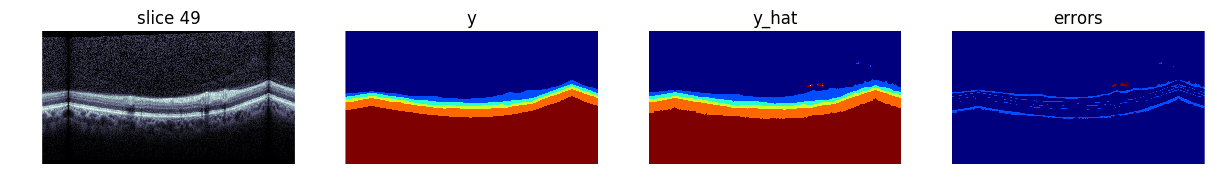

In [8]:
slices_to_view = valid_slices[:10]

for ts in slices_to_view:
    xi = np.squeeze(X[ts,...])
    yi = np.squeeze(Y[ts,...])
    yi_hat = Y_hat[ts,...]
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,4,1)
    plt.imshow(xi, interpolation='none', cmap='bone')
    plt.axis('off')
    plt.title('slice %d' % ts)
    
    plt.subplot(1,4,2)
    #plt.imshow(xi, interpolation='none', cmap='bone')
    plt.imshow(yi, interpolation='none', cmap='jet')
    plt.axis('off')
    plt.title('y')
    
    plt.subplot(1,4,3)
    plt.imshow(yi_hat, interpolation='none')
    plt.axis('off')
    plt.title('y_hat')
    
    plt.subplot(1,4,4)
    plt.imshow(np.abs(yi - yi_hat), interpolation='none')
    plt.axis('off')
    plt.title('errors')
    
    

(50, 1, 512, 748)
(50, 1, 512, 748)


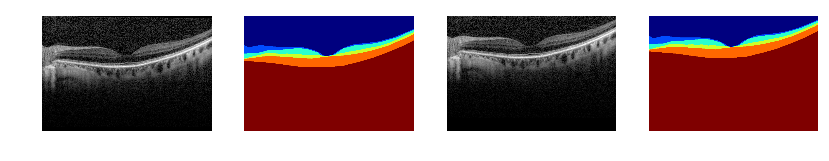

In [54]:
# here we are just visualizing the synthetic data augmentation.
print(X.shape)
print(Y.shape)

X_dy, Y_dy = train_oct.tian_shift_updown(X, Y)

idx = 0
plt.figure(figsize=(10,13))
plt.subplot(1,4,1)
plt.imshow(X[idx,0,...], interpolation=None, cmap='gray')
plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(Y[idx,0,...], interpolation=None, cmap='jet')
plt.axis('off')

plt.subplot(1,4,3)
plt.imshow(X_dy[idx,0,...], interpolation=None, cmap='gray'); plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(Y_dy[idx,0,...], interpolation=None, cmap='jet'); plt.axis('off')

plt.show()

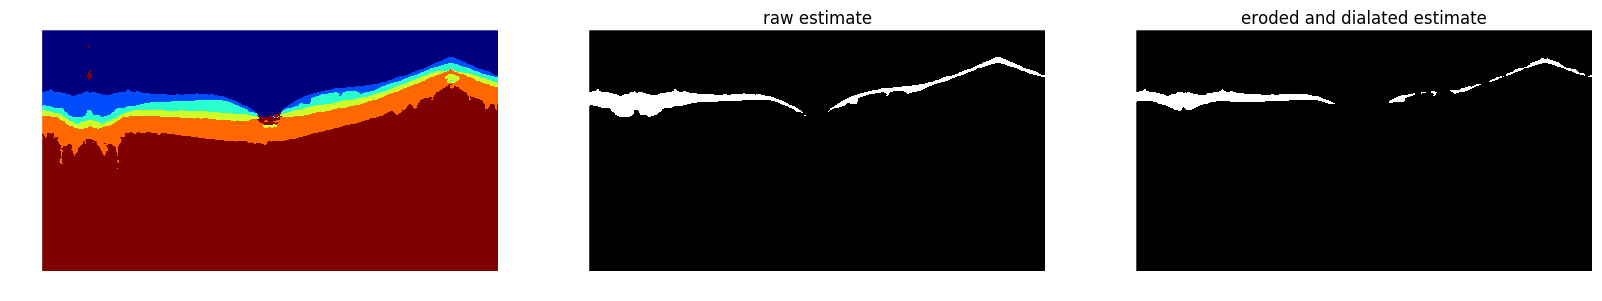

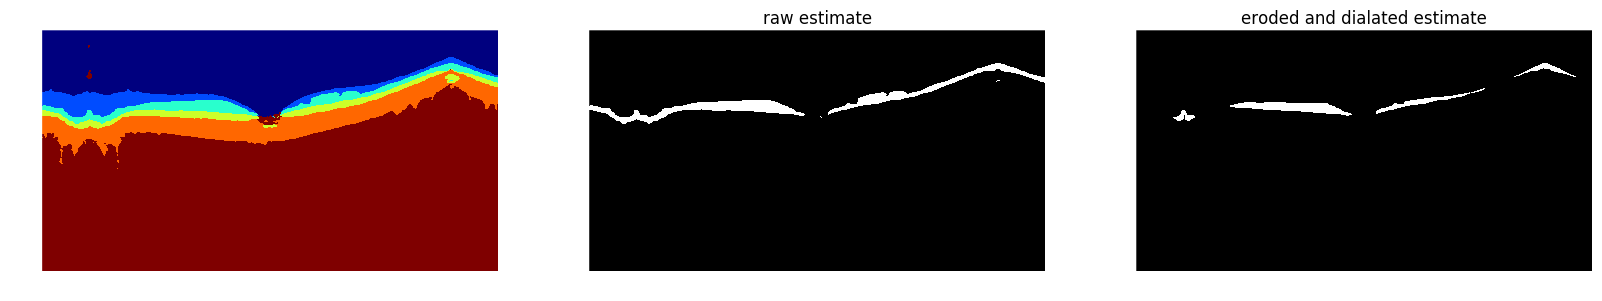

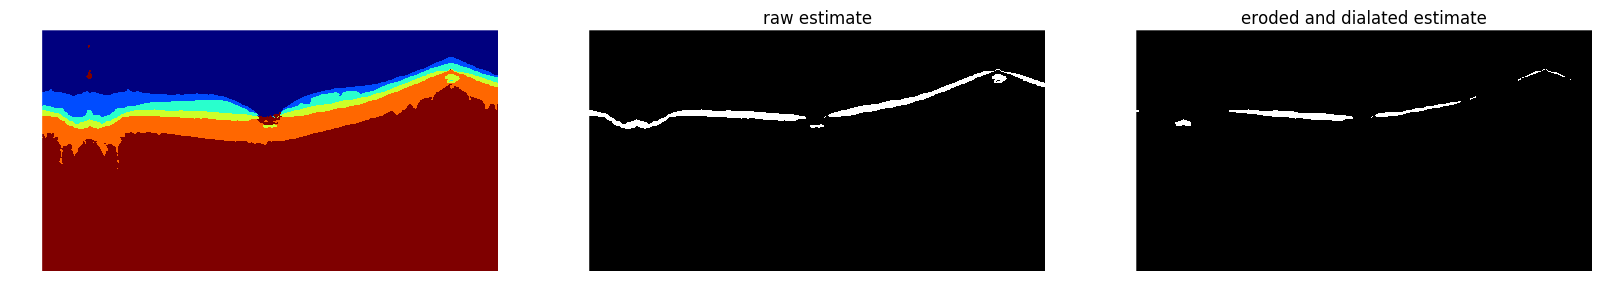

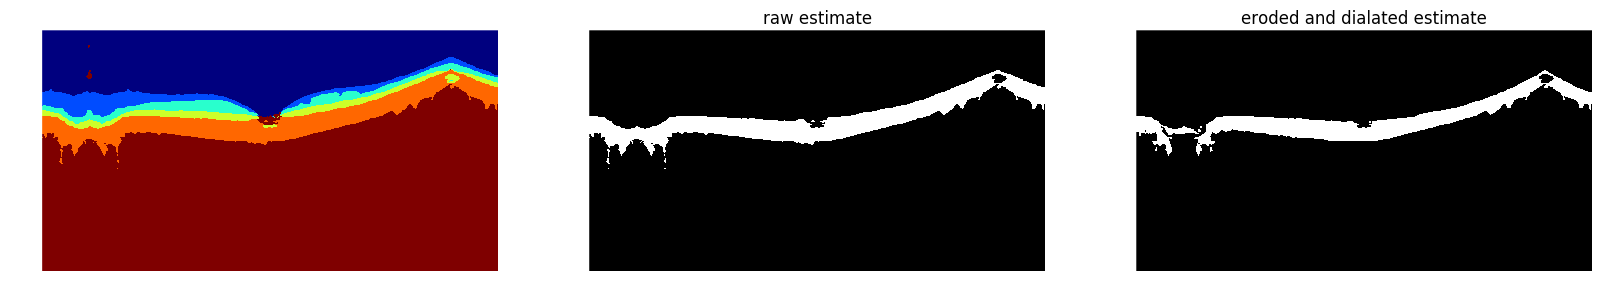

In [30]:
# experiment a bit with morphology operations

from skimage.morphology import opening

for yi in [1,2,3,4]:
    foo = Y_hat == yi
    bar = opening(foo)


    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1)
    plt.imshow(Y_hat[0,...], interpolation='none')
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(foo[0,...], interpolation='none', cmap='bone')
    plt.axis('off')
    plt.title('raw estimate')

    plt.subplot(1,3,3)
    plt.imshow(bar[0,...], interpolation='none', cmap='bone')
    plt.axis('off')
    plt.title('eroded and dialated estimate')

    plt.show()

GP_regression.,value,constraints,priors
rbf.variance,50.0,+ve,
rbf.lengthscale,100.0,+ve,
Gaussian_noise.variance,1.0,+ve,


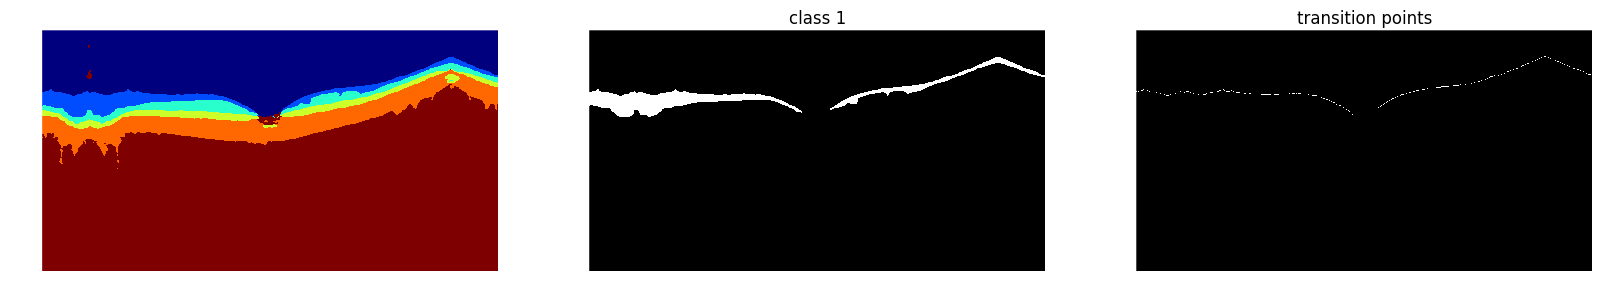

 /Users/pekalmj1/anaconda3/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


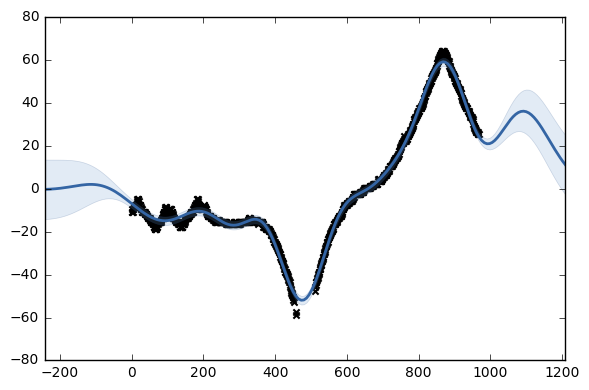

GP_regression.,value,constraints,priors
rbf.variance,50.0,+ve,
rbf.lengthscale,100.0,+ve,
Gaussian_noise.variance,1.0,+ve,


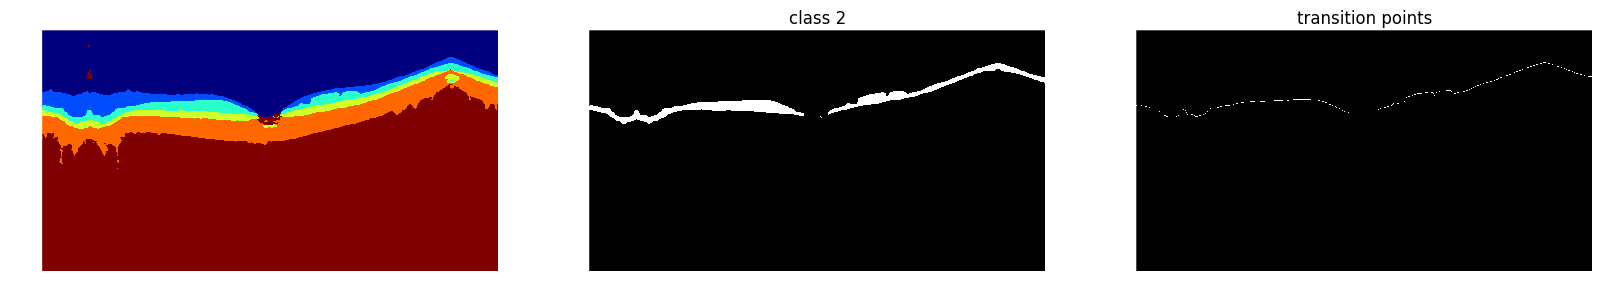

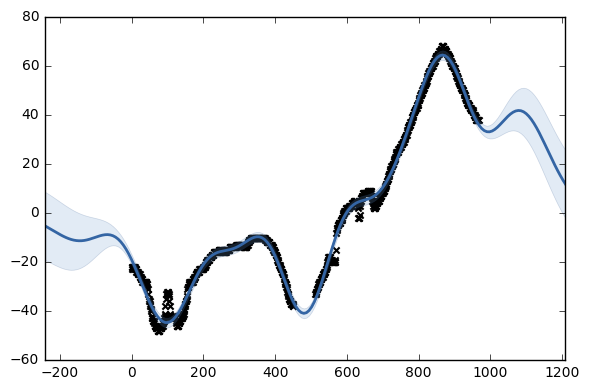

GP_regression.,value,constraints,priors
rbf.variance,50.0,+ve,
rbf.lengthscale,100.0,+ve,
Gaussian_noise.variance,1.0,+ve,


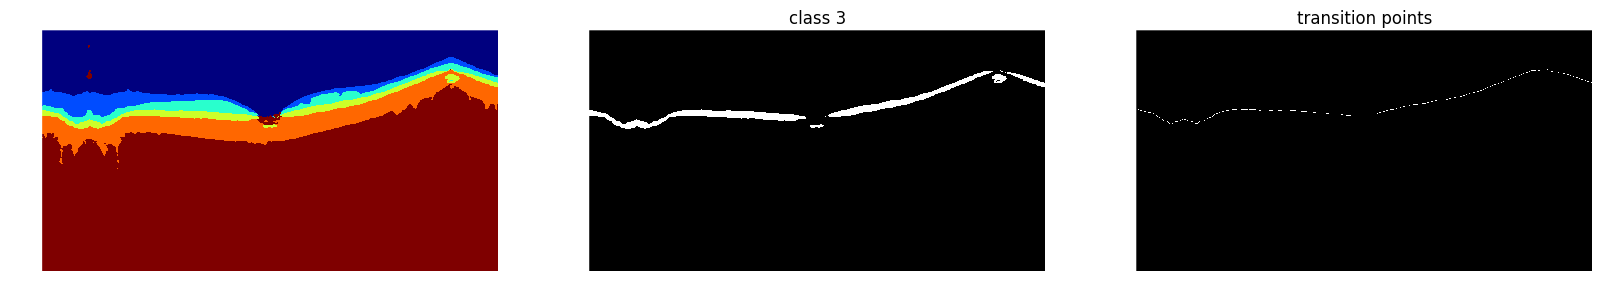

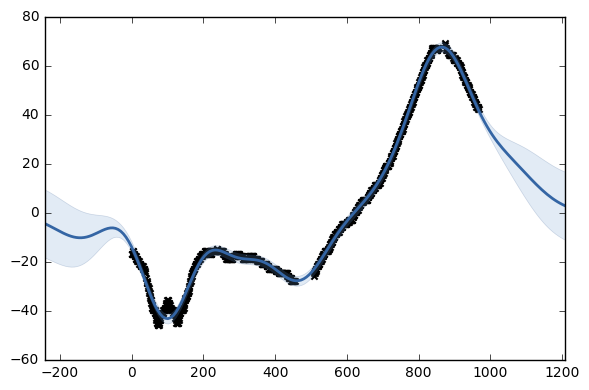

GP_regression.,value,constraints,priors
rbf.variance,50.0,+ve,
rbf.lengthscale,100.0,+ve,
Gaussian_noise.variance,1.0,+ve,


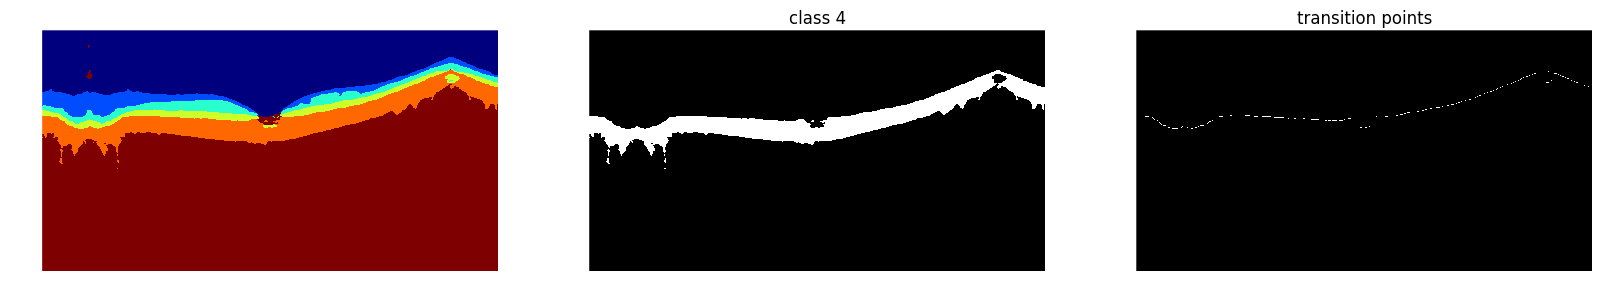

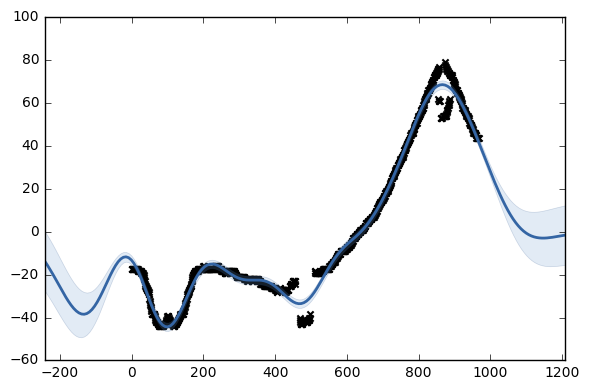

GP_regression.,value,constraints,priors
rbf.variance,50.0,+ve,
rbf.lengthscale,100.0,+ve,
Gaussian_noise.variance,1.0,+ve,


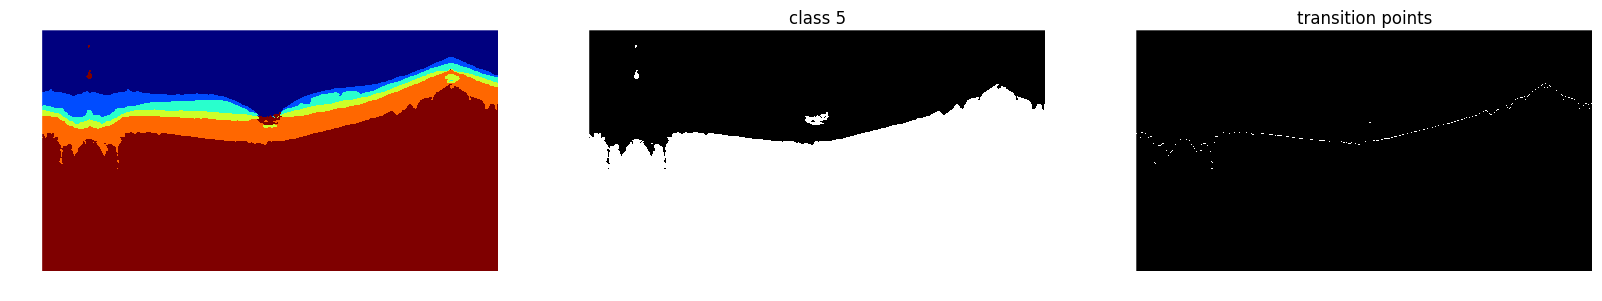

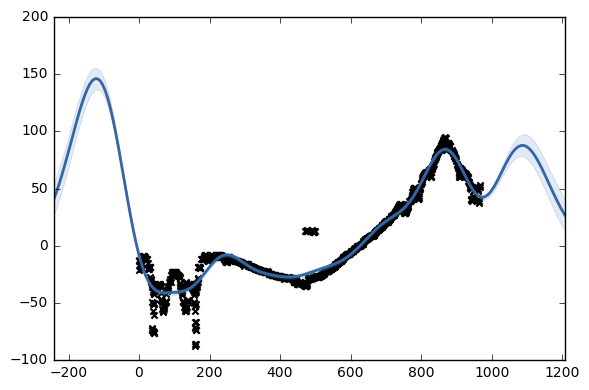

In [43]:
# here we experiment a bit with regression

# TODO: try again, but only using "high confidence" pixels??

# TODO: just discard all points that violate monotonicity??

import GPy
from skimage.morphology import opening


from IPython.display import display


kernel = GPy.kern.RBF(input_dim=1, variance=50., lengthscale=100.) # TODO

layers = []
means = []


for yi in [0,1,2,3,4]:
    Y0 = Y_hat[0,...]
    
    Yi = opening(Y0 == yi)
    Yii = opening(Y0 == (yi+1))
    
    Delta = np.logical_and(Yi, np.roll(Yii, -1, axis=0))
    rows,cols = np.nonzero(Delta)
        
    #deg = 5
    #p = np.polyfit(cols, rows, deg)
    #x_hat = np.arange(Delta.shape[1])
    #y_hat = p[0]
    #for ii in range(1,deg):
    #    y_hat += p[ii] * np.power(x_hat,ii)
   

    rows = Y0.shape[0] - rows # flipud to match images
    mu = np.mean(rows)
    rows = rows - mu
    means.append(mu)
    
    m = GPy.models.GPRegression(cols[:,np.newaxis], rows[:,np.newaxis], kernel)
    #m.optimize_restarts(num_restarts=2)
    layers.append(m)

    
    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1)
    plt.imshow(Y0, interpolation='none')
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(Yii, interpolation='none', cmap='bone')
    plt.axis('off')
    plt.title('class %d' % (yi+1))

    plt.subplot(1,3,3)
    plt.imshow(Delta, interpolation='none', cmap='bone')
    plt.axis('off')
    plt.title('transition points')
    

    display(m)
    fig = m.plot(legend=False)
    GPy.plotting.show(fig)
    plt.show()

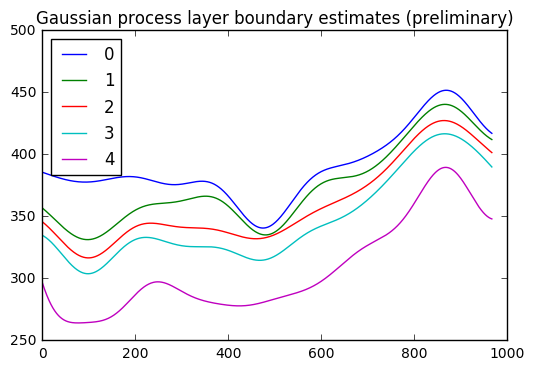

In [44]:
x = np.arange(Y0.shape[1])

plt.figure()
for idx, m in enumerate(layers):
    y_mu, y_sigma = np.squeeze(m.predict(x[:,np.newaxis]))
    plt.plot(x, means[idx] + y_mu, label=idx)

plt.legend(loc='upper left')
plt.title('Gaussian process layer boundary estimates (preliminary)')
plt.show()
